In [36]:
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

api_key = "08e9e39dec994c0d806a062bd1759df9"
headers = {"api_key": api_key}
url_lines = "http://api.wmata.com/Rail.svc/json/jLines"
response = requests.get(url_lines, headers=headers)

lines_df = pd.DataFrame(lines_data.get('Lines', []))
print("Lines DataFrame:")
print(lines_df.head())

url_stations = "http://api.wmata.com/Rail.svc/json/jStations"
response = requests.get(url_stations, headers=headers)

stations_df = pd.DataFrame(stations_data.get('Stations', []))
print("Stations DataFrame:")
print(stations_df[['Code', 'Name', 'LineCode1', 'LineCode2', 'LineCode3', 'LineCode4']].head())
stations_df = stations_df.drop_duplicates(subset=['Code'])


Lines DataFrame:
  LineCode DisplayName StartStationCode EndStationCode InternalDestination1  \
0       BL        Blue              J03            G05                        
1       GR       Green              F11            E10                        
2       OR      Orange              K08            D13                        
3       RD         Red              A15            B11                  A11   
4       SV      Silver              N06            G05                        

  InternalDestination2  
0                       
1                       
2                       
3                  B08  
4                       
Stations DataFrame:
  Code                           Name LineCode1 LineCode2 LineCode3 LineCode4
0  A01                   Metro Center        RD      None      None      None
1  A02                 Farragut North        RD      None      None      None
2  A03                  Dupont Circle        RD      None      None      None
3  A04  Woodley Park-Zoo/A

In [41]:
url_station_to_station = "http://api.wmata.com/Rail.svc/json/jSrcStationToDstStationInfo"
response = requests.get(url_station_to_station, headers=headers)
connections_df = pd.DataFrame(station_to_station_data.get('StationToStationInfos', []))
connections_df = connections_df.drop_duplicates(subset=['SourceStation', 'DestinationStation'])
print(connections_df[['SourceStation', 'DestinationStation', 'CompositeMiles']].head())

  SourceStation DestinationStation  CompositeMiles
0           A01                A02            0.75
1           A01                A03            1.23
2           A01                A04            2.40
3           A01                A05            3.10
4           A01                A06            3.73


In [47]:
stations_df = stations_df.drop_duplicates(subset=['Code'])
connections_df = connections_df.drop_duplicates(subset=['SourceStation', 'DestinationStation'])

G = nx.Graph()

for _, row in stations_df.iterrows():
    G.add_node(row['Code'], name=row['Name'])

for _, row in connections_df.iterrows():
    G.add_edge(row['SourceStation'], row['DestinationStation'], weight=row['CompositeMiles'])

degree_centrality = nx.degree_centrality(G)
degree_centrality_df = pd.DataFrame(degree_centrality.items(), columns=['StationCode', 'DegreeCentrality'])
degree_centrality_df = degree_centrality_df.merge(stations_df[['Code', 'Name']], left_on='StationCode', right_on='Code')
top_degree = degree_centrality_df.sort_values(by='DegreeCentrality', ascending=False).head(5)
print("Top 5 Stations by Degree:")
print(top_degree[['Name', 'DegreeCentrality']])
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
betweenness_centrality_df = pd.DataFrame(betweenness_centrality.items(), columns=['StationCode', 'BetweennessCentrality'])
betweenness_centrality_df = betweenness_centrality_df.merge(stations_df[['Code', 'Name']], left_on='StationCode', right_on='Code')
top_betweenness = betweenness_centrality_df.sort_values(by='BetweennessCentrality', ascending=False).head(5)
print("Top 5 Stations by Betweenness:")
print(top_betweenness[['Name', 'BetweennessCentrality']])

Top 5 Stations by Degree:
                                        Name  DegreeCentrality
101                                  Ashburn          1.019802
100                          Loudoun Gateway          1.019802
99   Washington Dulles International Airport          1.019802
98                         Innovation Center          1.019802
97                                   Herndon          1.019802
Top 5 Stations by Betweenness:
                    Name  BetweennessCentrality
15  Gallery Pl-Chinatown               0.018019
65  Gallery Pl-Chinatown               0.018019
97               Herndon               0.017576
96    Reston Town Center               0.017546
31               Rosslyn               0.017427


In [43]:
between = nx.betweenness_centrality(G, weight='weight')
betweenness_centrality_df = pd.DataFrame(between.items(), columns=['StationCode', 'BetweennessCentrality'])
betweenness_centrality_df = betweenness_centrality_df.merge(stations_df[['Code', 'Name']], left_on='StationCode', right_on='Code')
top_betweenness = betweenness_centrality_df.sort_values(by='BetweennessCentrality', ascending=False).head(5)
print("Top 5 Stations by Betweenness Centrality:")
print(top_betweenness[['Name', 'BetweennessCentrality']])

Top 5 Stations by Betweenness Centrality:
                    Name  BetweennessCentrality
15  Gallery Pl-Chinatown               0.018019
65  Gallery Pl-Chinatown               0.018019
97               Herndon               0.017576
96    Reston Town Center               0.017546
31               Rosslyn               0.017427


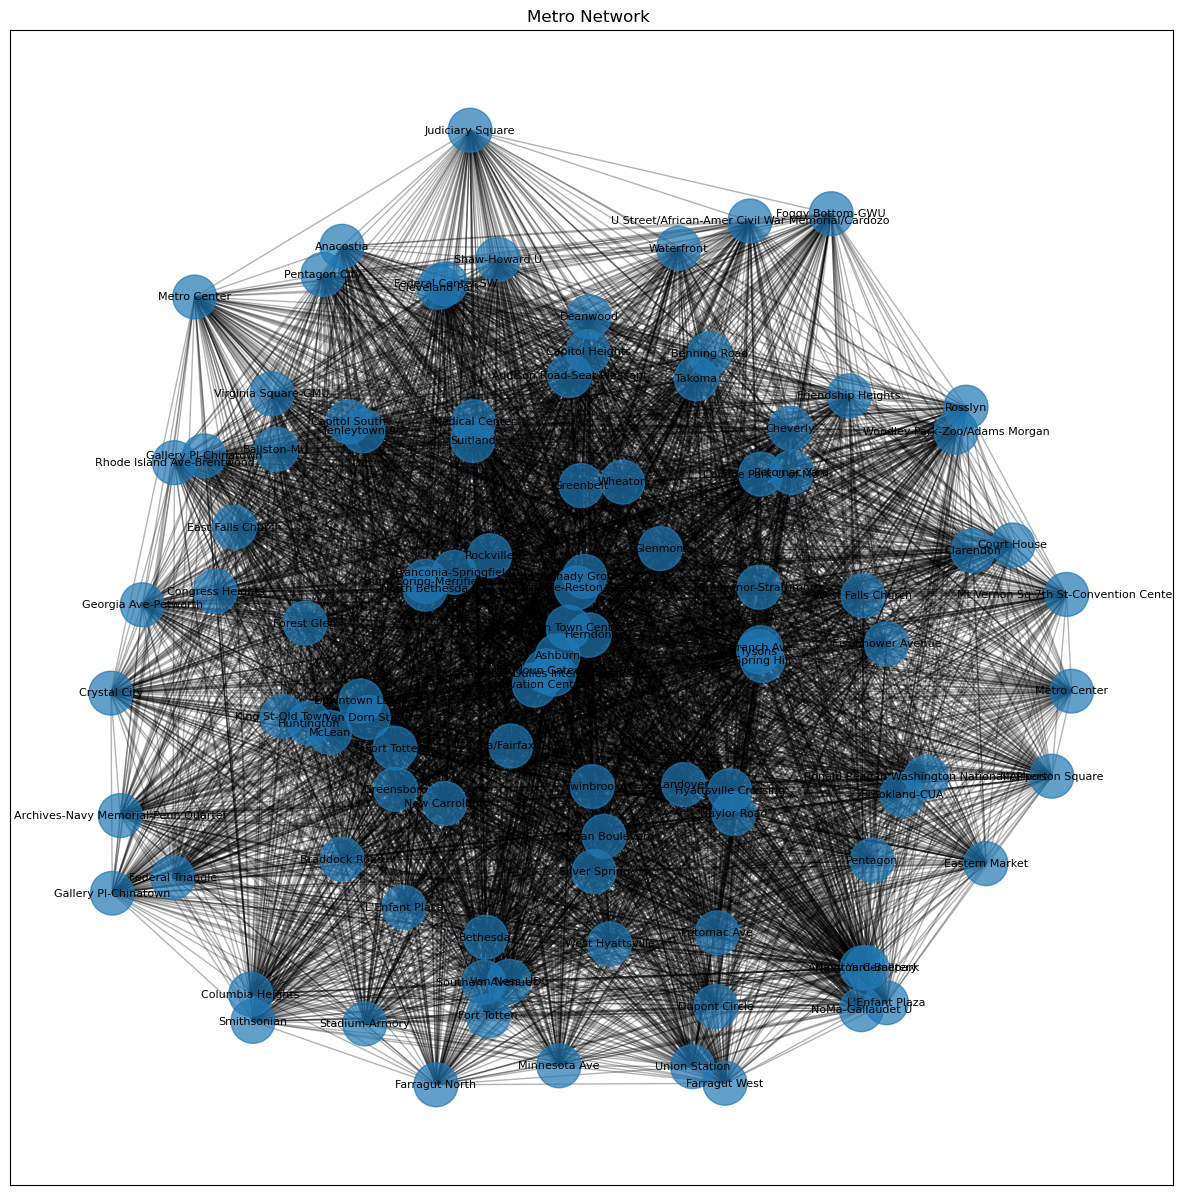

In [44]:
node_sizes = [degree_centrality[node] * 1000 for node in G.nodes()]
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, seed=42) 
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, {node: data['name'] for node, data in G.nodes(data=True)}, font_size=8)
plt.title("Metro Network ")
plt.show()
